In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN_final,GPN-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,hotpink
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [ ]:
dataset_renaming = {
    "mendelian_traits_matched_9": "Mendelian traits",
    "complex_traits_matched_9": "Complex traits",
}

subset_renaming = {
    "all": "All",
}

In [8]:
datasets = [
    "mendelian_traits_matched_9",
    "complex_traits_matched_9",
]

subsets = [
    "all",
    #"no_cadd_overlap",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    "Enformer",
    "Borzoi",
    "GPN_final",
    "NucleotideTransformer",
    "HyenaDNA",
    "Caduceus",
    "Sei",
    "SpeciesLM",
    "AIDO.DNA",
    "evo2_1b_base",
    "evo2_7b",
    "evo2_40b",
    "phyloP-100v",
    "phyloP-241m",
    "phastCons-43p",
]

model_zero_shot_score = {
    "mendelian_traits_matched_9": {
        "CADD": "CADD.plus.RawScore",
        "Enformer": "Enformer_L2_L2.plus.all",
        "Borzoi": "Borzoi_L2_L2.plus.all",
        "Sei": "Sei.plus.seqclass_max_absdiff",
        "GPN-MSA": "GPN-MSA_LLR.minus.score",
        "GPN_final": "GPN_final_LLR.minus.score",
        "NucleotideTransformer": "NucleotideTransformer_Embeddings.plus.euclidean_distance",
        "HyenaDNA": "HyenaDNA_Embeddings.minus.inner_product",
        "Caduceus": "Caduceus_Embeddings.plus.euclidean_distance",
        "SpeciesLM": "SpeciesLM_Embeddings.plus.euclidean_distance",
        "AIDO.DNA": "AIDO.DNA_Embeddings.minus.inner_product",

        "evo2_1b_base": "evo2_1b_base_Embeddings.plus.euclidean_distance",
        "evo2_7b": "evo2_7b_LLR.minus.score",
        "evo2_40b": "evo2_40b_LLR.minus.score",

        "phyloP-100v": "phyloP-100v.plus.score",
        "phyloP-241m": "phyloP-241m.plus.score",
        "phastCons-43p": "phastCons-43p.plus.score",
    },
    "complex_traits_matched_9": {
        "CADD": "CADD.plus.RawScore",
        "Enformer": "Enformer_L2_L2.plus.all",
        "Borzoi": "Borzoi_L2_L2.plus.all",
        "Sei": "Sei.plus.seqclass_max_absdiff",
        "GPN-MSA": "GPN-MSA_absLLR.plus.score",
        "GPN_final": "GPN_final_Embeddings.plus.euclidean_distance",
        "NucleotideTransformer": "NucleotideTransformer_Embeddings.minus.inner_product",
        "HyenaDNA": "HyenaDNA_Embeddings.minus.inner_product",
        "Caduceus": "Caduceus_Embeddings.minus.inner_product",
        "SpeciesLM": "SpeciesLM_Embeddings.plus.euclidean_distance",
        "AIDO.DNA": "AIDO.DNA_Embeddings.minus.inner_product",

        "evo2_1b_base": "evo2_1b_base_Embeddings.minus.inner_product",
        "evo2_7b": "evo2_7b_Embeddings.plus.euclidean_distance",
        "evo2_40b": "evo2_40b_absLLR.plus.score",

        "phyloP-100v": "phyloP-100v.plus.score",
        "phyloP-241m": "phyloP-241m.plus.score",
        "phastCons-43p": "phastCons-43p.plus.score",
    },
}

#metric = "AUPRC_by_chrom_weighted_average"
#metric = "AUROC_by_chrom_weighted_average"
#metric = "AUPRC"

metrics = [
    "AUPRC_by_chrom_weighted_average",
    #"AUROC_by_chrom_weighted_average",
    "AUPRC",
]

def get_model_path(model, modality, dataset, subset, metric):
    if modality == "Linear probing":
        if subset == "all":
            predictor = f"{model}.LogisticRegression.chrom"
        else:
            predictor = f"{model}.LogisticRegression.chrom.subset_from_all"
    elif modality == "Zero-shot":
        predictor = model_zero_shot_score[dataset][model]
    return f"../../results/dataset/{dataset}/{metric}/{subset}/{predictor}.csv"

In [9]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                for metric in metrics:
                    if modality == "Linear probing" and ("phyloP" in model or "phastCons" in model or metric == "AUPRC"):
                        continue
                    path = get_model_path(model, modality, dataset, subset, metric)
                    df = pd.read_csv(path).iloc[0]
                    rows.append([
                        dataset_renaming.get(dataset, dataset),
                        subset_renaming.get(subset, subset),
                        modality,
                        model_renaming.get(model, model),
                        df["score" if metric != "AUPRC" else metric],
                        df["se"],
                        metric,
                    ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se", "metric"])
df

,dataset,subset,modality,model,score,se,metric
0,Mendelian traits,All,Zero-shot,CADD,0.712185,0.038448,AUPRC_by_chrom_weighted_average
1,Mendelian traits,All,Zero-shot,CADD,0.694084,0.023481,AUPRC
2,Mendelian traits,All,Zero-shot,GPN-MSA,0.694475,0.041907,AUPRC_by_chrom_weighted_average
3,Mendelian traits,All,Zero-shot,GPN-MSA,0.688384,0.023188,AUPRC
4,Mendelian traits,All,Zero-shot,Enformer,0.418214,0.036752,AUPRC_by_chrom_weighted_average
...,...,...,...,...,...,...,...
91,Complex traits,All,Linear probing,SpeciesLM,0.184830,0.007555,AUPRC_by_chrom_weighted_average
92,Complex traits,All,Linear probing,AIDO.DNA,0.152089,0.005050,AUPRC_by_chrom_weighted_average
93,Complex traits,All,Linear probing,Evo2 1B,0.143010,0.005253,AUPRC_by_chrom_weighted_average
94,Complex traits,All,Linear probing,Evo2 7B,0.149925,0.004982,AUPRC_by_chrom_weighted_average


In [ ]:
#df.to_csv("results.csv", index=False)

In [13]:
def plot_subset(subset, metric):
    df_s = df.query("subset == @subset and metric == @metric").rename(columns={"score": metric})

    g = sns.FacetGrid(
        df_s,
        col="dataset",
        row="modality",
        margin_titles=True,
        sharex="col",
        sharey=False,#"row",
        #height=2.2,
        #aspect=1.35,
        #height=2.5,
        #aspect=1.3,
        height=4,
        aspect=1.0,
    )

    def my_boxplot(data, **kwargs):
        data = data.sort_values(metric, ascending=False)
        ax = plt.gca()
        g = sns.barplot(
            data=data,
            y="model",
            x=metric,
            ax=ax,
            palette=palette,
            #showfliers=False, whis=0, # optional
        )
        ax.errorbar(
            x=data[metric],
            y=data["model"],
            xerr=data["se"],
            fmt='none',      # Do not add markers (those are already in the pointplot)
            color="black",
        )

    g.map_dataframe(my_boxplot)

    g.set(
        ylabel="",
        xlim=0.1 if "AUPRC" in metric else 0.5,
        xlabel=metric.replace("_by_chrom_weighted_average", "")
    )
    g.set_titles(
        col_template="{col_name}", row_template="{row_name}",
        fontweight="bold",
        size=12,
    )
    g.tight_layout()
    #plt.savefig(f"../../results/plots/performance_{subset}_{metric}.pdf", bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

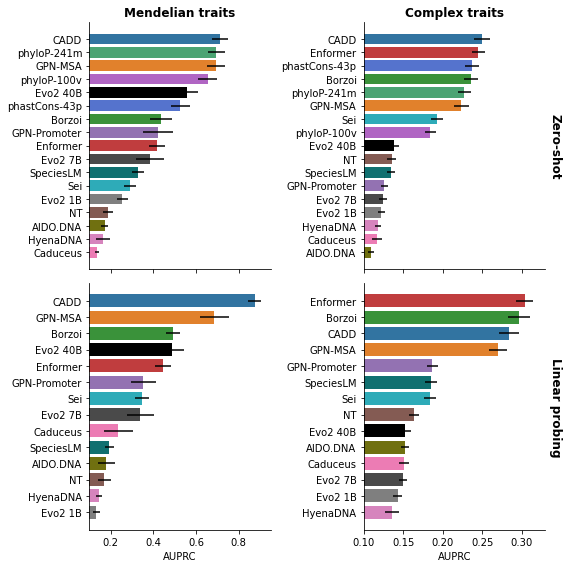

In [14]:
plot_subset("All", "AUPRC_by_chrom_weighted_average")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

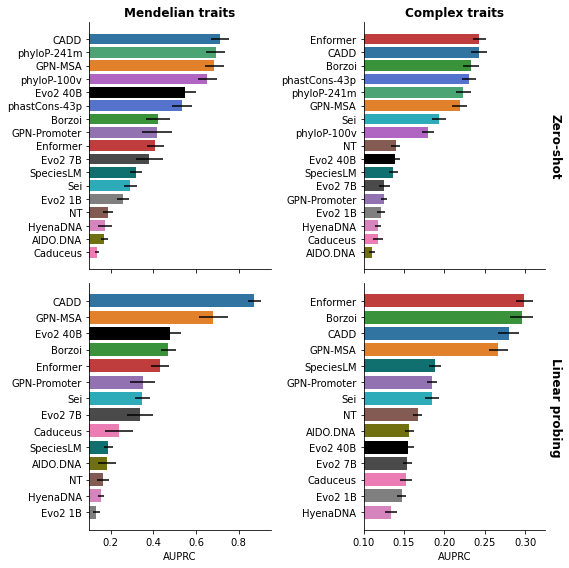

In [36]:
plot_subset("no_cadd_overlap")